In [ ]:
# !nvidia-smi

In [ ]:
# !pip install -q git+git://github.com/fastai/fastcore.git
# !pip install -q git+git://github.com/fastai/fastai2.git
# !pip install -q git+git://github.com/lgvaz/faststyle.git@weights

In [ ]:
from fastai.vision.all import *
from faststyle import *

In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)
  root_dir = Path('/content/gdrive/My Drive/dl')
except ImportError:
  root_dir = Path.home()/'dl'
root_dir.mkdir(exist_ok=True)

In [ ]:
# source = untar_data(URs.COCO_SAMPLE)
source = Path('/notebooks/storage/data/coco_sample')

In [ ]:
fns = get_image_files(source)

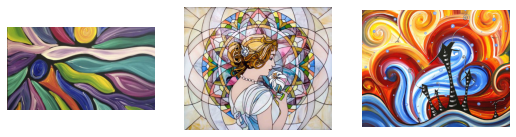

In [ ]:
style_dir = Path('styles')
style_fns = L('abstract.jpg', 'mosaic.jpg', 'village.jpg')
style_fns = style_fns.map(lambda o: style_dir/o)
show_images([PILImage.create(fn) for fn in style_fns])

In [ ]:
class RandomizeExtreme(Transform):
  def encodes(self, x:Weights):
    i = random.randint(0, len(x)-1)
    w = np.random.uniform(.6)
    ws = (1-w)/(len(x)-1) * torch.ones(len(x))
    ws[i] = w
    return ws

In [ ]:
def get_items(path, n=3):
  fns = get_image_files(source)
  return fns.map(lambda o: [o, random_weights(n)])

In [ ]:
fns_pairs = get_items(source)
dset = Datasets(fns_pairs, splits=RandomSplitter()(fns),
                tfms=[[ImageWeight.create], [itemgetter(0), PILImage.create]])

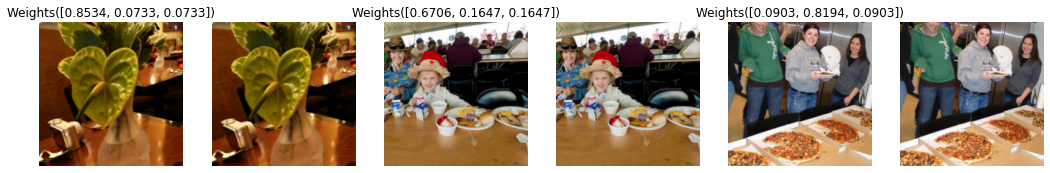

In [ ]:
dls = dset.dataloaders(bs=42,
                       after_item=[ToTensor, Resize(256), RandomizeExtreme()],
                       after_batch=[IntToFloatTensor, *aug_transforms(size=224),
                                    NormalizeX.from_stats(*coco_stats),])
dls.show_batch(max_n=3)

In [ ]:
layer_feats = LayerFeats.from_feat_m(FeatModels.vgg19)

In [ ]:
loss_func = FastStyleLoss(stl_w=1e5, tv_w=300)
cbs = [FeatsCallback.from_fns(style_fns, layer_feats), WeightsCallback()]
learn = Learner(dls, TransformerNet2(3), loss_func, cbs=cbs, metrics=loss_func.metrics)
learn.path = root_dir/'faststyle'; learn.path.mkdir(exist_ok=True)

In [ ]:
learn.load('ws-abs_mos_vil-512_1e5_2') 

In [ ]:
learn.fit_one_cycle(5, 1e-3, pct_start=0.2)

epoch,train_loss,valid_loss,stl,cnt,tv,time
0,26.620945,27.208206,6.430694,16.114262,4.663243,09:25
1,26.046419,26.458979,6.383585,15.303470,4.771927,09:25
2,25.464388,26.037315,6.634862,14.628137,4.774309,09:25
3,25.015963,25.287474,6.494782,14.146263,4.646432,09:26
4,24.721245,25.409781,6.535402,14.142222,4.732150,09:25


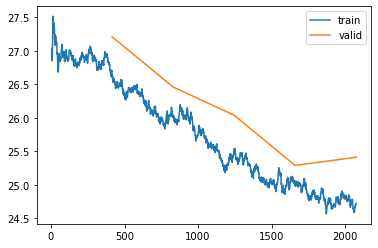

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.save('softws-abs_mos_vil-224_1e5')

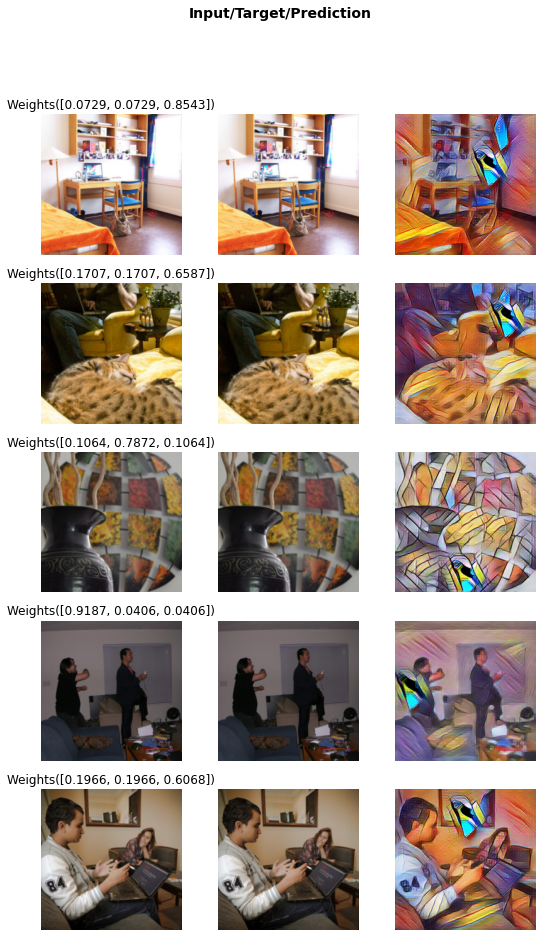

In [ ]:
learn.show_results()

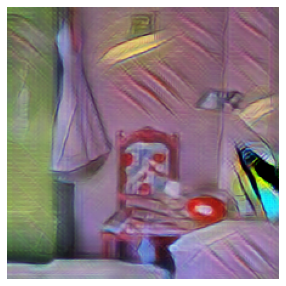

In [ ]:
# Randomize weights being applied here, consider using split_idx
pred,_,_=learn.predict([fns[5], [.9, .05, .05]])
pred.show()

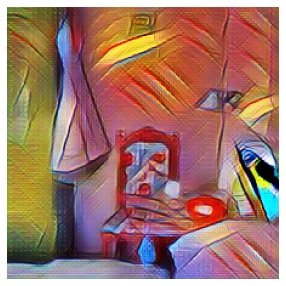

In [ ]:
pred,_,_=learn.predict([fns[5], [0., 0., 1.]])
pred.show()

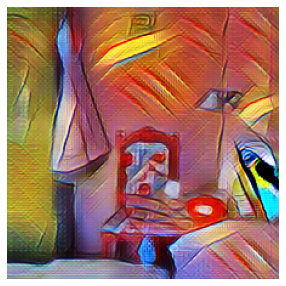

In [ ]:
pred,_,_=learn.predict([fns[5], [.01, .98, .01]])
pred.show()

In [ ]:
fns_test = fns_pairs[:10]
dl = learn.dls.test_dl(fns_test, bs=1,
                       after_item=[RatioResize(512), ToTensor()],
                       after_batch=[IntToFloatTensor(), NormalizeX.from_stats(*coco_stats)])

In [ ]:
inp,targ,_,preds = learn.get_preds(dl=dl, with_decoded=True, with_input=True)

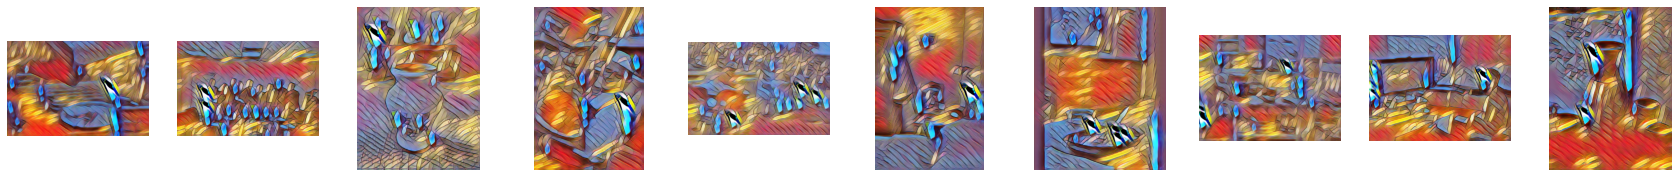

In [ ]:
show_images(preds)

In [ ]:
export_dir = learn.path/'exports'; export_dir.mkdir(exist_ok=True)
learn.export(export_dir/'stl_weights448.pkl')